<a href="https://colab.research.google.com/github/deedf/covid_data/blob/main/covid_vaccine_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First run this and restart the runtime.

!pip install lockfile matplotlib --upgrade


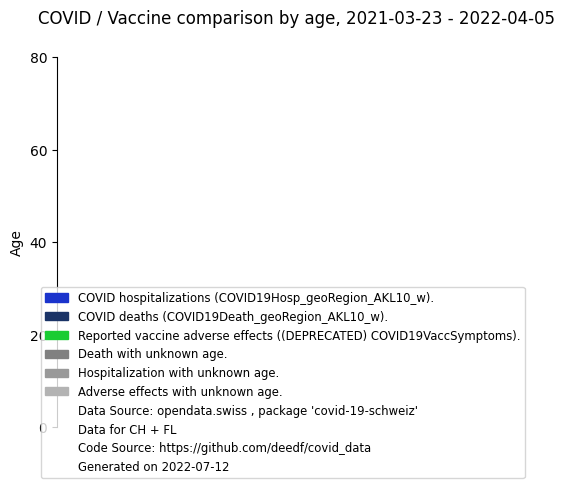

In [18]:
#!/usr/bin/env python3
"""
Make symptoms graph.
"""
import logging
from collections import namedtuple
from datetime import date
from pathlib import Path
from typing import Any, Dict, List, Tuple
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import requests
from cachecontrol import CacheControl
from cachecontrol.caches import FileCache
from requests import Response
import pandas as pd
from io import StringIO

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

cached_sess = CacheControl(
  requests.Session(), cache=FileCache(Path.home() / ".webcache")
)


PACKAGE_NAME="covid-19-schweiz"

PACKAGE_URL = (
    f"https://ckan.opendata.swiss/api/3/action/package_show"
)

START_DATE = date(2021, 3, 23)
END_DATE = date(2022, 4, 5)
DEATH_COLOR = (0.1, 0.2, 0.4)
HOSP_COLOR = (0.1, 0.2, 0.8)
SYMPTOM_COLOR = (0.1, 0.8, 0.2)
DEATH_UNKNOWN_COLOR = (0.5, 0.5, 0.5)
HOSP_UNKNOWN_COLOR = (0.6, 0.6, 0.6)
SYMPTOM_UNKNOWN_COLOR = (0.7, 0.7, 0.7)
TRANSPARENT_COLOR = (0,0,0,0)

AGE_BAR_DICT = {
    "0 - 9": (0, 9),
    "10 - 19": (10, 19),
    "20 - 29": (20, 29),
    "30 - 39": (30, 39),
    "40 - 49": (40, 49),
    "50 - 59": (50, 59),
    "60 - 69": (60, 69),
    "70 - 79": (70, 79),
    "80+": (80, 89),
    "Unbekannt": (90, 99),
    "0 - 1": (0, 1),
    "12 - 17": (12, 17),
    "18 - 44": (18, 44),
    "2 - 11": (2, 11),
    "45 - 64": (45, 64),
    "65 - 74": (65, 74),
    "75+": (75, 89),
    "unknown": (90, 99),
}
CovidData = namedtuple("CovidData", ["hosp", "death", "symptoms"])


def _get_package(id: str) -> Dict[str, Any]:
    result = cached_sess.get(PACKAGE_URL,params={'id':id})
    result.raise_for_status()
    return result.json()["result"]


def _get_data(
    package_url: str, date_attr: str, cutoff_date: str
) -> List[Dict[str, str]]:
    result: Response = cached_sess.get(package_url)
    result.raise_for_status()
    p = pd.read_csv(StringIO(result.text))
    return p[ (p[date_attr] == cutoff_date) & (p['geoRegion'] == "CHFL")]


def _get_all_data(
    death: Dict[str, Any], hosp: Dict[str, Any], symptoms: Dict[str, Any], at_date: date
) -> CovidData:
    iso_calendar = date.isocalendar(at_date)
    date_iso = str(iso_calendar[0]) + str(iso_calendar[1])
    death_data = _get_data(death["download_url"], "datum", date_iso)
    hosp_data = _get_data(hosp["download_url"], "datum", date_iso)
    symptom_data = _get_data(symptoms["download_url"], "date", at_date.isoformat())
    symptom_data = symptom_data[
         (symptom_data["vaccine"] == "all") &
         (symptom_data["age_group"] != "all") &
         (symptom_data["severity"] == "all")
        ]
    return CovidData(hosp_data, death_data, symptom_data)


def _diff(start: Dict[str, Any], end: Dict[str, Any]) -> Dict[str, Any]:
    return dict([(k, end[k] - start[k]) for k in end.keys()])


def _build_graph(
    death: Dict[str, Any], hosp: Dict[str, Any], symptoms: Dict[str, Any]
) -> None:
    start = _get_all_data(death, hosp, symptoms, START_DATE)
    end = _get_all_data(death, hosp, symptoms, END_DATE)
    counts = CovidData(
        end.hosp['sumTotal'] - start.hosp['sumTotal'] ,
        end.death['sumTotal'] - start.death['sumTotal'],
        end.symptoms['sumTotal'] - start.symptoms['sumTotal'])
    plt.rcdefaults()
    fig, plot = plt.subplots()
    fig.suptitle(f"COVID / Vaccine comparison by age, {START_DATE} - {END_DATE}")
    for age in counts.death.keys():
        death_count: int = counts.death[age]
        (y_1, y_2) = AGE_BAR_DICT[age]
        height: int = y_2 - y_1
        d_width = death_count / height
        if death_count > 0:
            plot.barh(
                y=y_1,
                width=-d_width,
                left=0,
                height=height,
                align="edge",
                color=HOSP_UNKNOWN_COLOR if age == "Unbekannt" else DEATH_COLOR,
                edgecolor=(0, 0, 0),
                linewidth=1,
            )
        hosp_count: int = counts.hosp[age]
        if hosp_count > 0:
            (y_1, y_2) = AGE_BAR_DICT[age]
            height = y_2 - y_1
            b = plot.barh(
                y=y_1,
                width=-hosp_count / height,
                left=-d_width,
                height=height,
                align="edge",
                color=DEATH_UNKNOWN_COLOR if age == "Unbekannt" else HOSP_COLOR,
                edgecolor=(0, 0, 0),
                linewidth=1,
            )
            plot.bar_label(b, labels=[f"   {hosp_count + death_count} "])
    for age in counts.symptoms.keys():
        count: int = counts.symptoms[age]
        if count > 0:
            (y_1, y_2) = AGE_BAR_DICT[age]
            height = y_2 - y_1
            b = plot.barh(
                y=y_1,
                width=count / height,
                left=10,
                height=height,
                align="edge",
                color=SYMPTOM_UNKNOWN_COLOR if age == "unknown" else SYMPTOM_COLOR,
                edgecolor=(0, 0, 0),
                linewidth=1,
            )
            plot.bar_label(b, labels=[f" {count}"])
    plot.xaxis.set_visible(False)
    plot.set_ylabel("Age")
    plot.set_yticks([0, 20, 40, 60, 80])
    legends: List[Tuple[Tuple, str]] = [
        (HOSP_COLOR, f"COVID hospitalizations ({hosp['display_name']['en']})."),
        (DEATH_COLOR, f"COVID deaths ({death['display_name']['en']})."),
        (SYMPTOM_COLOR, f"Reported vaccine adverse effects ({symptoms['display_name']['en']})."),
    ]
    # if counts.death["age_group"]["Unbekannt"] > 0:
    legends.append((DEATH_UNKNOWN_COLOR, "Death with unknown age."))
    # if counts.hosp["age_group"]["Unbekannt"] > 0:
    legends.append((HOSP_UNKNOWN_COLOR, "Hospitalization with unknown age."))
    #if counts.symptoms["age_group"]["unknown"] > 0:
    legends.append((SYMPTOM_UNKNOWN_COLOR, "Adverse effects with unknown age."))
    legends.append((TRANSPARENT_COLOR,f"Data Source: opendata.swiss , package '{PACKAGE_NAME}'"))
    legends.append((TRANSPARENT_COLOR,f"Data for CH + FL"))
    legends.append((TRANSPARENT_COLOR,f"Code Source: https://github.com/deedf/covid_data"))
    legends.append((TRANSPARENT_COLOR,f"Generated on {datetime.now().strftime('%Y-%m-%d')}"))

    fig.legend(
        [Rectangle(xy=(0, 0), width=10, height=10, color=l[0]) for l in legends],
        [l[1] for l in legends],
        loc="lower center",
        fontsize="small"
    )
    plt.margins(0.1, 0.1)
    plot.spines["top"].set_visible(False)
    plot.spines["right"].set_visible(False)
    plot.spines["bottom"].set_visible(False)
    plt.show()


def _main() -> None:
    packages = _get_package(PACKAGE_NAME)
    resources_json: List[Dict[str, Any]] = packages["resources"]
    resources_dict: Dict[str, Dict[str, Any]] = dict(
        [(r["identifier"], r) for r in resources_json]
    )
    _build_graph(
        resources_dict["weekly-death-age-range-csv"],
        resources_dict["weekly-hosp-age-range-csv"],
        resources_dict["daily-vacc-symptoms-csv"],
    )


if __name__ == "__main__":
    _main()


# New Section